In [2]:
"""
READ COMMON DATASET FORMAT
PARSE occurencedate
PARSE crimename
SEPARATE INTO TRAINING AND TEST
CHOOSE MODEL - KMeans
TRY DIFFERENT MODELS - get best results
Plot predictions on map

SEND TO TORONTO CITY HALL
WRITE ARTICLE ABOUT IT
SEND TO GLOBAL/CTV
"""

'\nREAD COMMON DATASET FORMAT\nPARSE occurencedate\nPARSE crimename\nSEPARATE INTO TRAINING AND TEST\nCHOOSE MODEL - KMeans\nTRY DIFFERENT MODELS - get best results\nPlot predictions on map\n\nSEND TO TORONTO CITY HALL\nWRITE ARTICLE ABOUT IT\nSEND TO GLOBAL/CTV\n'

In [3]:
"""
Occurence year/month/day/hour - day of week as result of math
Offence - one hot encoding
Lat/Lng - Neighborhood (but as a result of lat lng - no onehot encoding)

"""

'\nOccurence year/month/day/hour - day of week as result of math\nOffence - one hot encoding\nLat/Lng - Neighborhood (but as a result of lat lng - no onehot encoding)\n\n'

In [4]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d.axes3d import Axes3D

import seaborn as sns

from isodate import parse_datetime
import datetime
import time
import dateutil.parser as dp

%matplotlib inline

In [5]:
#prep
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MaxAbsScaler, QuantileTransformer

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression, Ridge, RidgeCV
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.metrics.pairwise import euclidean_distances

In [6]:
#validation libraries
from sklearn.cross_validation import KFold, StratifiedKFold
from IPython.display import display
from sklearn import metrics

c:\python36\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [7]:
total_set = pd.read_csv("robbery.csv")
req_set = total_set[["occurrencemonth", "occurrencedayofweek", "occurrencehour", "Lat", "Long"]]
req_set.drop(req_set.index[503], inplace=True)

month_enc = LabelEncoder()
month_enc.fit(req_set.occurrencemonth.astype(str))
req_set.occurrencemonth = month_enc.transform(req_set.occurrencemonth.astype(str))

day_enc = LabelEncoder()
day_enc.fit(req_set.occurrencedayofweek.astype(str))
req_set.occurrencedayofweek = day_enc.transform(req_set.occurrencedayofweek.astype(str))

print(req_set.head(2))

stan_scaler = StandardScaler().fit(req_set)
req_set = stan_scaler.transform(req_set)

# print(month_enc.classes_)
# print(day_enc.classes_)

"""
['April' 'August' 'December' 'February' 'January' 'July' 'June' 'March'
 'May' 'November' 'October' 'September']
['Friday    ' 'Monday    ' 'Saturday  ' 'Sunday    ' 'Thursday  '
 'Tuesday   ' 'Wednesday ']
"""

c:\python36\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
c:\python36\lib\site-packages\pandas\core\generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


   occurrencemonth  occurrencedayofweek  occurrencehour        Lat       Long
0                7                    4              21  43.731232 -79.434601
1                7                    4              23  43.743645 -79.603912


"\n['April' 'August' 'December' 'February' 'January' 'July' 'June' 'March'\n 'May' 'November' 'October' 'September']\n['Friday    ' 'Monday    ' 'Saturday  ' 'Sunday    ' 'Thursday  '\n 'Tuesday   ' 'Wednesday ']\n"

In [11]:
# reduc = PCA(n_components=2).fit(req_set)
# reduc = reduc.transform(req_set)
# plt.hist2d(reduc[:,0], reduc[:,1])
# plt.plot()

In [8]:
Nc = range(1, 20)

kmeans = [KMeans(n_clusters=i) for i in Nc]

score = [kmeans[i].fit(req_set).score(req_set) for i in range(len(kmeans))]

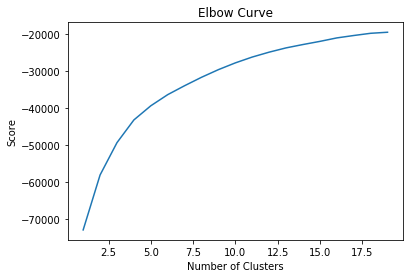

In [9]:
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

###IDEAL NUMBER IS 3

In [10]:
k_means = cluster.KMeans(n_clusters=3)
k_means.fit(req_set)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [11]:
# new_point = [9, 0, 17, 43.71311993, -79.39601716]

#43.757390, -79.517541 is jane and finch
new_point = np.array([9, 0, 21, 43.75738, -79.517541]).reshape(1,-1)
new_point = stan_scaler.transform(new_point)

In [12]:
centers = k_means.cluster_centers_

In [13]:
def find_smallest(n_scr, cents):
    n_scr = np.array([n_scr]).astype(float)
    lowest_score = 100000
    lowest_index = 0
    index = 0
    for cent in cents:
        cur_score = euclidean_distances(n_scr, [cent])
        if cur_score < lowest_score:
            lowest_score = cur_score
            lowest_index = index
        index += 1
    return lowest_score, lowest_index

In [14]:
testpoint_smallest, testpoint_ind = find_smallest(new_point[0], centers)

In [15]:
all_dists = 0
for i in req_set:
    scr, ind = find_smallest(i, centers)
    if scr < 1.1 * testpoint_smallest[0][0] and scr > 0.9 * testpoint_smallest[0][0]:
        all_dists += 1

In [17]:
all_lats = []
all_longs = []
prediction_arrs = []

In [18]:
def create_predictions():
    index = 0
    now = datetime.datetime.now()
    for lat in range(43662478, 43775351, 641):
        for long in range(79314937,79521751, 1533):
            new_point = np.array([9, 0,now.hour,lat/1000000,long/1000000]).reshape(1,-1)
            scaled_point = stan_scaler.transform(new_point)
            cur_score, cur_index = find_smallest(scaled_point[0], k_means.cluster_centers_)
#             new_point.append(cur_score[0][0])
#             new_point.append(cur_index)
            index += 1
            print(cur_score)
#         print(str(index) + "/" + str(len(all_lats) * len(all_longs)))

    #Lat = 43.638 - 43.813, intervals of 0.001
    #Long = -79.52 - -79.33 intervals of 0.001